In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import numpy as np
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.pipeline_utils.file_utils import get_date
from utils.processing_utils import ds_functions
from transformations.grid_transformation import Transformation

In [2]:
ds_name = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/harvested_granules/2013/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3_20130101.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
if 'preprocessing' in config:
    preprocessing_func = config['preprocessing']
    callable_func = getattr(ds_functions, preprocessing_func)
    ds = callable_func(sample_granule_path, config)
else:
    ds = xr.open_dataset(sample_granule_path, decode_times=True)
ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time           datetime64[ns] ...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (lat, lon) float64 ...
    uncertainty    (lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
    GAD            (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2024-01-02T14:01:30Z

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                   (time: 1, tile: 13, j: 90, i: 90,
                                               nv: 2)
Coordinates:
  * time                                      (time) datetime64[ns] 2013-01-1...
  * tile                                      (tile) int16 0 1 2 3 ... 10 11 12
  * j                                         (j) int16 0 1 2 3 ... 86 87 88 89
  * i                                         (i) int16 0 1 2 3 ... 86 87 88 89
    XC                                        (tile, j, i) float32 -111.6 ......
    YC                                        (tile, j, i) float32 -88.24 ......
    time_bnds                                 (time, nv) datetime64[ns] 2013-...
Dimensions without coordinates: nv
Data variables:
    lwe_thickness_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.96...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       JPL GRACE and GRACE-FO Mascon Ocean, Ice, a...
    original_dataset_short_name:  TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/TELLUS_...
    original_dataset_reference:   https://podaac.jpl.nasa.gov/GRACE
    original_dataset_doi:         10.5067/TEMSC-3JC63
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.6
    notes:

# Visualization

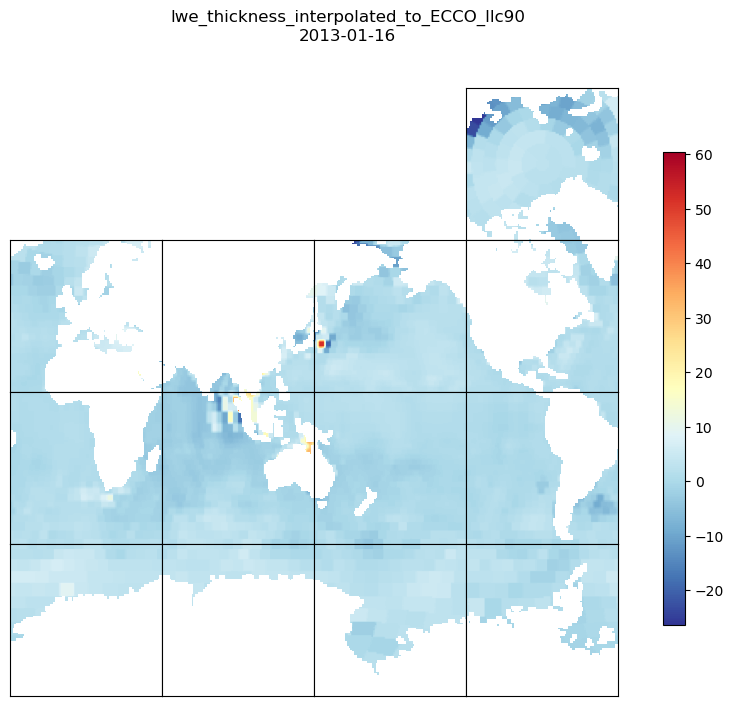

In [13]:
field_ds = field_ds_list[0]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]])

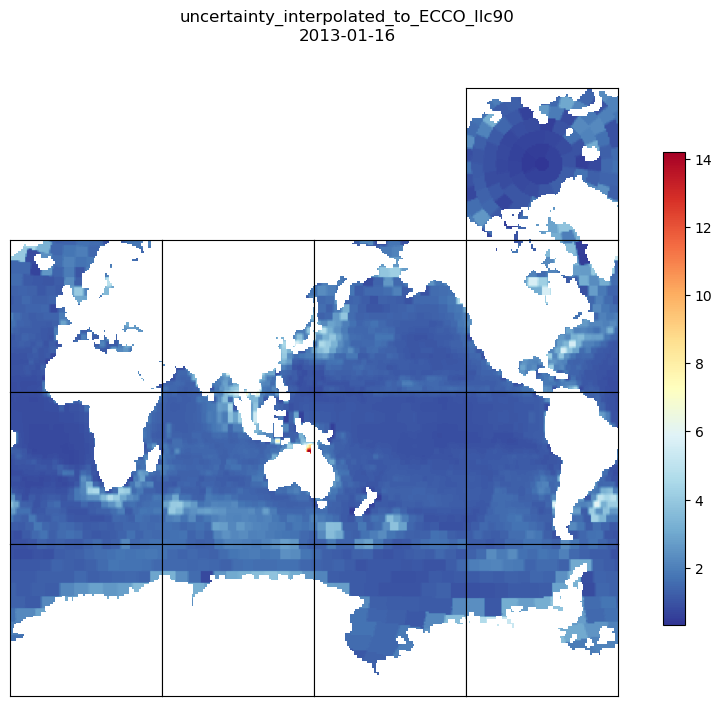

In [12]:
field_ds = field_ds_list[1]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]])